In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.contrib.layers import fully_connected

%matplotlib inline

/Users/alexmansano/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
n_inputs = 4
n_hidden = 4
n_outputs = 1

learning_rate = 0.01

In [3]:
initializer = tf.contrib.layers.variance_scaling_initializer()

In [4]:
X = tf.placeholder(tf.float32, shape=[None, n_inputs])
hidden =fully_connected(X, n_hidden, activation_fn=None, weights_initializer=initializer)
logits = fully_connected(hidden, n_outputs, activation_fn=None, weights_initializer=initializer)
outputs = tf.nn.sigmoid(logits) #gera distrib de probabilidade

In [5]:
p_left_and_right = tf.concat(axis=1, values=[outputs, 1 - outputs])
action = tf.multinomial(tf.log(p_left_and_right), num_samples=1) #faz o sampling de acordo com as probabilidades

In [6]:
y = 1. - tf.to_float(action)
cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits)

In [7]:
optimizer = tf.train.AdamOptimizer(learning_rate)
grads_and_vars = optimizer.compute_gradients(cross_entropy)

In [24]:
gradient_placeholders = []
grads_and_vars_feed = []
gradients = [grad for grad, var in grads_and_vars]

cria placeholder para atribuir os gradientes após ajustá-los

In [32]:
for grad, variable in grads_and_vars:
    gradient_placeholder = tf.placeholder(tf.float32, shape=grad.get_shape())
    gradient_placeholders.append(gradient_placeholder)
    grads_and_vars_feed.append((gradient_placeholder, variable))

In [33]:
training_op = optimizer.apply_gradients(grads_and_vars_feed)

In [34]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

Também são necessárias funções para calcularmos o total discounted reward e normaliza-lo em todos os episódios

In [12]:
def discount_rewards(rewards, discount_rate):
    discounted_rewards = np.empty(len(rewards))
    cumulative_rewards = 0
    for step in reversed(range(len(rewards))):
        cumulative_rewards = rewards[step] + cumulative_rewards * discount_rate
        discounted_rewards[step] = cumulative_rewards
    return discounted_rewards

In [28]:
def discount_and_normalize_rewards(all_rewards, discount_rate):
    all_discounted_rewards = [discount_rewards(rewards, discount_rate)
                              for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean)/reward_std
           for discounted_rewards in all_discounted_rewards]

Agora podemos treinar nossa política

In [14]:
import gym
import time

In [15]:
env = gym.make("CartPole-v0")

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [20]:
obs = env.reset()

In [21]:
n_iterations = 250 #numero de iteracoes de treinamento
n_max_steps = 1000 #numero maximo de steps por episodio
n_games_per_update = 10 #traina a politica a cada 10 episodios
save_iterations = 10 #salva o modelo a cada 10 iteracoes
discount_rate = 0.95

In [37]:
with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        all_rewards = [] # sequencias de rewards para cada episodio
        all_gradients = [] # gradientes de cada step de cada episodio
        for game in range(n_games_per_update):
            current_rewards = []
            current_gradients = []
            obs = env.reset()
            for step in range(n_max_steps):
                action_val, gradients_val = sess.run(
                    [action, gradients],
                    feed_dict={X: obs.reshape(1, n_inputs)}) #position1
                obs, reward, done, info = env.step(action_val[0][0])
                current_rewards.append(reward)
                current_gradients.append(gradients_val)
                if done:
                    break
            all_rewards.append(current_rewards)
            all_gradients.append(current_gradients)
        
        #podemos agora atualizar nossa política
        all_rewards = discount_and_normalize_rewards(all_rewards, discount_rate)
        feed_dict = {}
        for var_index, grad_placeholder in enumerate(gradient_placeholders):
            #multiplica os gradients pelo score e calcula a media
            mean_gradients = np.mean(
                [reward*all_gradients[game_index][step][var_index]
                 for game_index, rewards in enumerate(all_rewards)
                 for step, reward in enumerate(rewards)],
                axis=0)
            feed_dict[grad_placeholder] = mean_gradients
        sess.run(training_op, feed_dict=feed_dict)
        if iteration % save_iterations == 0:
            saver.save(sess, "./my_policy_net_pg.cktp")

Agora que treinamos nosso modelo a escolher as acoes de acordo com o estado (políticas), vamos ver como ele se comporta

In [69]:
from IPython import display

def show_state(env, step=0, info=""):
    plt.figure(3)
    plt.clf()
    plt.imshow(env.render(mode='rgb_array'))
    plt.title("Step: %d %s" % (step, info))
    plt.axis('off')

    display.clear_output(wait=True)
    display.display(plt.gcf())

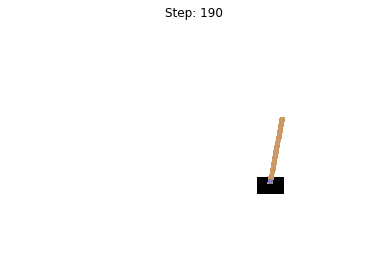

reward 1.0


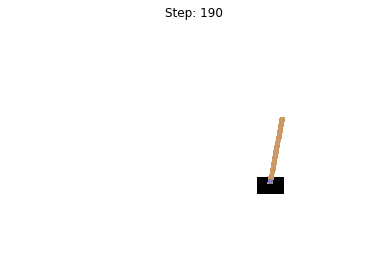

In [85]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

with tf.Session() as sess:
    saver.restore(sess, "./my_policy_net_pg.cktp")
    
    obs = env.reset()
    for step in range(10000):
        obs, reward, done, _ = env.step(action.eval(feed_dict={X: np.expand_dims(obs, axis=0)})[0][0])
        if step % 10 == 0:
            show_state(env.env, step)
        if done:
            print('reward', reward)
            #show_state(env.env, step)
            break